# TP Integrador Aprendizaje Automático I

### Librerías

In [161]:
import pandas as pd
import numpy as np
import seaborn as sns
import nbimporter
from funciones import *
from geopy.distance import geodesic
from sklearn.linear_model import LinearRegression

### Carga de datos y exploración

In [162]:
### Carga datos de dataset
### Contiene aproximadamente 10 años de observaciones diarias de variables climáticas: temperatura, dirección y velocidad del viento, humedad, presión, nubosidad, y cantidad de lluvia en mm.
### tras observar los datos del día de hoy, el objetivo es predecir las variables target:
###                                                                                     -RainFallTomorrow: cantidad de lluvia del día posterior a la observación. Problema de Regresión.
###                                                                                     -RainTomorrow: si el día siguiente llueve o no llueve. Problema de Clasificación.
file_path= 'weatherAUS.csv'
df = pd.read_csv(file_path, sep=',',engine='python')

# Lista de ubicaciones permitidas
allowed_locations = ['Adelaide', 'Canberra', 'Cobar', 'Dartmoor', 'Melbourne', 'MelbourneAirport', 'MountGambier', 'Sydney', 'SydneyAirport']

# Eliminar las demás ubicaciones del DataFrame original
df = df[df['Location'].isin(allowed_locations)]


In [163]:
### Vista de datos
df.head()

,Unnamed: 0,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,RainfallTomorrow
6047,6049,2009-01-01,Cobar,17.9,35.2,0.0,12.0,12.3,SSW,48.0,...,13.0,1006.3,1004.4,2.0,5.0,26.6,33.4,No,No,0.0
6048,6050,2009-01-02,Cobar,18.4,28.9,0.0,14.8,13.0,S,37.0,...,8.0,1012.9,1012.1,1.0,1.0,20.3,27.0,No,No,0.0
6049,6051,2009-01-03,Cobar,15.5,34.1,0.0,12.6,13.3,SE,30.0,...,7.0,NaN,1011.6,NaN,1.0,NaN,32.7,No,No,0.0
6050,6052,2009-01-04,Cobar,19.4,37.6,0.0,10.8,10.6,NNE,46.0,...,22.0,1012.3,1009.2,1.0,6.0,28.7,34.9,No,No,0.0
6051,6053,2009-01-05,Cobar,21.9,38.4,0.0,11.4,12.2,WNW,31.0,...,22.0,1012.7,1009.1,1.0,5.0,29.1,35.6,No,No,0.0


In [164]:
# Se elimina la primer columna con el índice
df = df.drop('Unnamed: 0', axis=1)

In [170]:
# Se analizan los tipos de datos que conforman el dataset
print(df.dtypes)

Date                  int64
Location             object
MinTemp             float64
MaxTemp             float64
Rainfall            float64
Evaporation         float64
Sunshine            float64
WindGustDir         float64
WindGustSpeed       float64
WindDir9am          float64
WindDir3pm          float64
WindSpeed9am        float64
WindSpeed3pm        float64
Humidity9am         float64
Humidity3pm         float64
Pressure9am         float64
Pressure3pm         float64
Cloud9am            float64
Cloud3pm            float64
Temp9am             float64
Temp3pm             float64
RainToday           boolean
RainTomorrow        boolean
RainfallTomorrow    float64
dtype: object


In [166]:
# Se convierte la columna 'Date' de string (object) a datetime
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')

# Se toma como fecha base la mínima fecha del df
fecha_base = df['Date'].min()

# Se calcula el número de días desde la fecha base
df['Date'] = (df['Date'] - fecha_base).dt.days


In [167]:
#Se reemplaza 'Yes' por 1 y 'No' por 0 en las columnas RainToday y RainTomorrow
# errors='coerce' permite conservar los nan aún cambiando el tipo de datos a booleano
df['RainToday'] = pd.to_numeric(df['RainToday'].replace({'Yes': 1, 'No': 0}), errors='coerce').astype('boolean')
df['RainTomorrow'] = pd.to_numeric(df['RainTomorrow'].replace({'Yes': 1, 'No': 0}), errors='coerce').astype('boolean')

C:\Users\julia\AppData\Local\Temp\ipykernel_10224\84528137.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['RainToday'] = pd.to_numeric(df['RainToday'].replace({'Yes': 1, 'No': 0}), errors='coerce').astype('boolean')
C:\Users\julia\AppData\Local\Temp\ipykernel_10224\84528137.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['RainTomorrow'] = pd.to_numeric(df['RainTomorrow'].replace({'Yes': 1, 'No': 0}), errors='coerce').astype('boolean')


In [168]:
#Se mapean las direcciones dadas ('SSW', 'S', 'SE', etc.) a números del 0 al 15 según las agujas del reloj
directions_mapping = {
    'N': 0,
    'NNE': 1,
    'NE': 2,
    'ENE': 3,
    'E': 4,
    'ESE': 5,
    'SE': 6,
    'SSE': 7,
    'S': 8,
    'SSW': 9,
    'SW': 10,
    'WSW': 11,
    'W': 12,
    'WNW': 13,
    'NW': 14,
    'NNW': 15
}

In [169]:
# Se reemplaza en df los nuevos valores
df['WindGustDir'] = df['WindGustDir'].replace(directions_mapping)
df['WindDir9am'] = df['WindDir9am'].replace(directions_mapping)
df['WindDir3pm'] = df['WindDir3pm'].replace(directions_mapping)

C:\Users\julia\AppData\Local\Temp\ipykernel_10224\216544107.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['WindGustDir'] = df['WindGustDir'].replace(directions_mapping)
C:\Users\julia\AppData\Local\Temp\ipykernel_10224\216544107.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['WindDir9am'] = df['WindDir9am'].replace(directions_mapping)
C:\Users\julia\AppData\Local\Temp\ipykernel_10224\216544107.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain th

In [114]:
df.describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainfallTomorrow
count,27663.000000,27675.000000,27247.000000,23880.000000,21520.000000,26588.000000,26591.000000,26585.000000,27796.000000,27875.000000,27893.000000,27293.000000,27343.000000,27394.000000,27404.000000,18866.000000,18683.000000,27648.000000,27657.000000,27248.000000
mean,11.263319,21.902078,2.050369,4.826499,6.891129,7.711110,41.835471,7.376378,8.048928,15.130152,20.023052,68.766350,50.497385,1018.249325,1016.149624,4.668557,4.732805,15.477127,20.408345,2.049347
std,5.709936,6.693168,6.384560,3.707995,3.867622,4.694183,14.186300,5.054644,4.503144,9.458606,8.979409,18.730306,19.944931,7.423776,7.267376,2.807571,2.628154,5.701031,6.532302,6.383931
min,-8.000000,4.100000,0.000000,0.000000,0.000000,0.000000,9.000000,0.000000,0.000000,0.000000,0.000000,5.000000,1.000000,982.300000,984.900000,0.000000,0.000000,-1.300000,3.700000,0.000000
25%,7.400000,16.600000,0.000000,2.200000,3.800000,4.000000,31.000000,2.000000,4.000000,9.000000,13.000000,57.000000,37.000000,1013.300000,1011.300000,1.000000,2.000000,11.400000,15.400000,0.000000
50%,10.900000,21.000000,0.000000,4.000000,7.400000,8.000000,39.000000,8.000000,8.000000,13.000000,19.000000,70.000000,50.000000,1018.400000,1016.300000,6.000000,6.000000,15.000000,19.500000,0.000000
75%,15.200000,26.200000,1.000000,6.600000,10.000000,12.000000,50.000000,12.000000,12.000000,20.000000,26.000000,83.000000,64.000000,1023.300000,1021.100000,7.000000,7.000000,19.125000,24.500000,1.000000
max,33.900000,46.800000,119.400000,86.200000,14.300000,15.000000,122.000000,15.000000,15.000000,69.000000,76.000000,100.000000,100.000000,1040.600000,1037.900000,9.000000,8.000000,38.600000,46.100000,119.400000


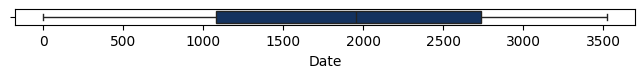

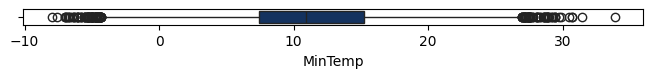

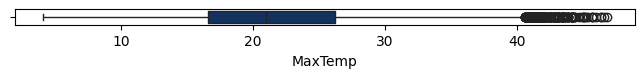

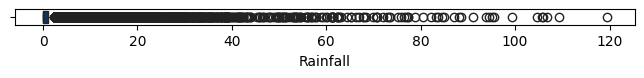

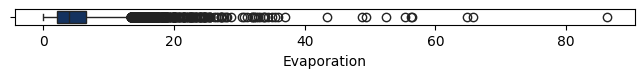

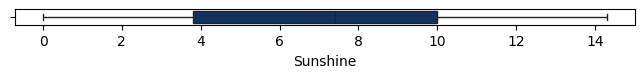

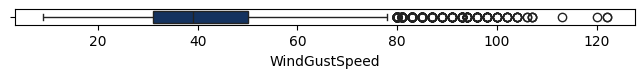

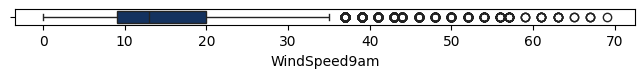

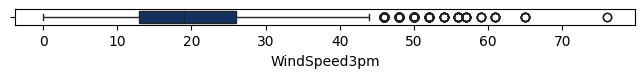

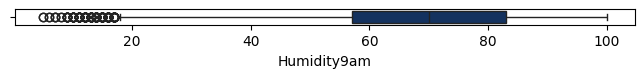

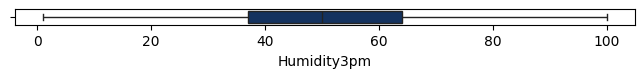

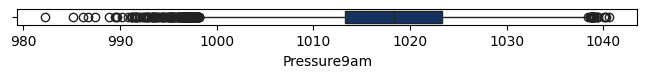

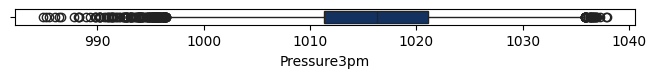

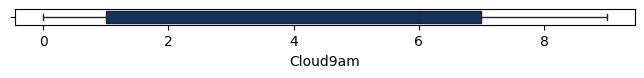

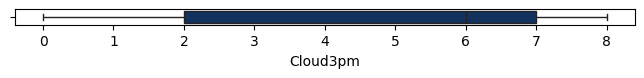

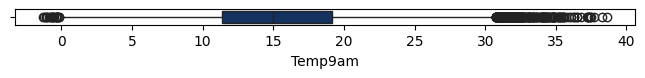

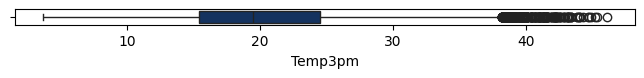

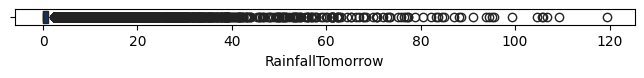

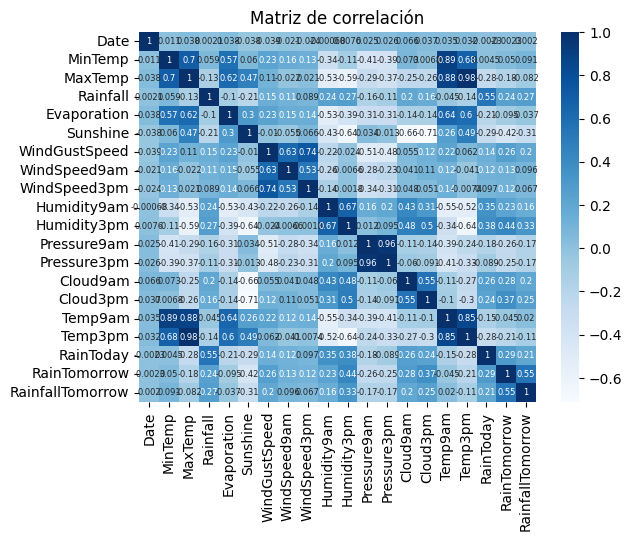

In [155]:
explorar(df)

### Partición del Dataframe

In [172]:
# Se chequea que todas las fechas tengan un valor
df['Date'].isna().sum()

0

Se particiona el df en df_train y df_test en una proporción aproximada de 80% 20%, correspondiendo los del df_train a los datos cronológicamente más antiguos.

In [179]:
# Ordenamiento por la columna 'Date'
df = df.sort_values('Date')

# Calcular el índice que corresponde al 80% del DataFrame
index_at_80_percent = int(len(df_sorted) * 0.8)

# Usar el índice para obtener la fecha en ese punto
date_at_80_percent = df_sorted.iloc[index_at_80_percent]['Date']

# Crear df_train y df_test basado en esta fecha
df_train = df_sorted[df_sorted['Date'] <= date_at_80_percent]
df_test = df_sorted[df_sorted['Date'] > date_at_80_percent]

# Mostrar el número de registros en cada conjunto
print(f"Entrenamiento: {len(df_train)} registros")
print(f"Prueba: {len(df_test)} registros")
print(f"Suma de registro Entrenamiento y Prueba: {len(df_test)+len(df_train)} registros")
print(f"Cantidad total de registros en df original: {df.shape[0]} registros")


Entrenamiento: 22590 registros
Prueba: 5643 registros
Suma de registro Entrenamiento y Prueba: 28233 registros
Cantidad total de registros en df original: 28233 registros


### Análisis de valores nulos

#### Primeros análisis

Se cuentan los valores nulos por variable, comenzando por aquellas en donde se supera el 5% de la totalidad de los datos.

In [180]:
print(int(0.05 * df_train.shape[0]))

1129


In [181]:
### Cantidad de valores faltantes.
df_train.isna().sum().sort_values(ascending=False)

Cloud3pm            7469
Cloud9am            7179
Sunshine            3962
Evaporation         2016
WindGustDir         1571
WindGustSpeed       1568
WindDir9am          1415
RainfallTomorrow     742
Rainfall             742
RainToday            742
RainTomorrow         742
Pressure9am          625
Pressure3pm          618
Humidity9am          605
Humidity3pm          561
WindDir3pm           414
Temp9am              372
Temp3pm              366
MinTemp              357
WindSpeed9am         350
MaxTemp              344
WindSpeed3pm         336
Location               0
Date                   0
dtype: int64

Se analiza a continuación cada variable, con su variable más correlacionada, y la cantidad de nulos de cada una:

In [182]:
df_con_nan=df_train
analisis_nan(df_con_nan)

g:\Mi unidad\TUIA\IA4.1 AA I\Trabajo Práctico Integrador\AA1-TUIA-Garcia-Herrera\funciones.py:93: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_nan = pd.concat([df_nan, pd.DataFrame({'Columna': [columna],


,Columna,Max_Abs_Correlacion,Valor_Correlacion,Valores_NaN
0,Date,Pressure3pm,0.072729,0
1,MinTemp,Temp9am,0.892961,357
2,MaxTemp,Temp3pm,0.982767,344
3,Rainfall,RainToday,0.550871,742
4,Evaporation,Temp9am,0.652501,2016
5,Sunshine,Cloud3pm,-0.708560,3962
6,WindGustDir,WindDir3pm,0.545980,1571
7,WindGustSpeed,WindSpeed3pm,0.742479,1568
8,WindDir9am,WindGustDir,0.368278,1415
9,WindDir3pm,WindGustDir,0.545980,414


In [101]:
# Se reemplazan los nan con la siguiente función, para las variables más correlacionadas
recrear_nan(df_train,'MinTemp','Temp9am')
analisis_nan(df_train)

g:\Mi unidad\TUIA\IA4.1 AA I\Trabajo Práctico Integrador\AA1-TUIA-Garcia-Herrera\funciones.py:93: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_nan = pd.concat([df_nan, pd.DataFrame({'Columna': [columna],


,Columna,Max_Abs_Correlacion,Valor_Correlacion,Valores_NaN
0,Date,Cloud9am,0.066170,0
1,MinTemp,Temp9am,0.893197,559
2,MaxTemp,Temp3pm,0.982436,558
3,Rainfall,RainToday_Yes,0.552161,986
4,Evaporation,Temp9am,0.643411,4353
5,Sunshine,Cloud3pm,-0.710729,6713
6,WindGustDir,WindDir3pm,0.541424,1645
7,WindGustSpeed,WindSpeed3pm,0.739562,1642
8,WindDir9am,WindGustDir,0.358306,1648
9,WindDir3pm,WindGustDir,0.541424,437


Se observa que las variables Cloud9am y Cloud3pm no presentan una fuerte correlación con las demás, al punto de considerar reconstruir los valores nulos mediante regresión lineal.
Es por eso que se hace a continuación un análisis más detallado para estas variables.

#### Análisis nulos para Cloud9am

Se construye una matriz con las distancias entre ciudades, que ayudará a comprender la posibilidad de adoptar valores de ciudades aledañas:

In [84]:
# Coordenadas de las ciudades
cities_coords = {
    'Adelaide': (-34.9285, 138.6007),
    'Canberra': (-35.2809, 149.1300),
    'Cobar': (-31.4983, 145.8344),
    'Dartmoor': (-37.9225, 141.2760),
    'Melbourne': (-37.8136, 144.9631),
    'MelbourneAirport': (-37.6690, 144.8410),
    'MountGambier': (-37.8284, 140.7804),
    'Sydney': (-33.8688, 151.2093),
    'SydneyAirport': (-33.9399, 151.1753)
}

# Crear un DataFrame vacío
dist_matrix = pd.DataFrame(index=cities_coords.keys(), columns=cities_coords.keys())

# Calcular las distancias y llenar la matriz
for city1 in cities_coords:
    for city2 in cities_coords:
        dist = geodesic(cities_coords[city1], cities_coords[city2]).kilometers
        dist_matrix.at[city1, city2] = round(dist, 2)

# Mostrar la matriz de distancias
print(dist_matrix)


                 Adelaide Canberra   Cobar Dartmoor Melbourne  \
Adelaide              0.0   960.32  773.97   409.76    654.36   
Canberra           960.32      0.0  519.56   761.08    467.02   
Cobar              773.97   519.56     0.0   825.72    705.11   
Dartmoor           409.76   761.08  825.72      0.0    324.63   
Melbourne          654.36   467.02  705.11   324.63       0.0   
MelbourneAirport   637.49   466.79  690.56   315.23     19.32   
MountGambier       376.54   798.82  840.92    44.84    368.24   
Sydney            1164.53   246.85   568.4   1002.5    713.86   
SydneyAirport     1160.17   239.41   569.1   995.89    706.42   

                 MelbourneAirport MountGambier   Sydney SydneyAirport  
Adelaide                   637.49       376.54  1164.53       1160.17  
Canberra                   466.79       798.82   246.85        239.41  
Cobar                      690.56       840.92    568.4         569.1  
Dartmoor                   315.23        44.84   1002.5      

El siguiente df...

In [85]:
# DataFrame para almacenar la ciudad más cercana y la distancia
closest_city_and_distance = pd.DataFrame(index=cities_coords.keys(), columns=['Nearest City', 'Distance (km)'])

# Encontrar la ciudad más cercana y la distancia para cada una
for city in dist_matrix.columns:
    closest_city = dist_matrix[city].drop(city).idxmin()
    closest_distance = dist_matrix.at[city, closest_city]
    closest_city_and_distance.at[city, 'Nearest City'] = closest_city
    closest_city_and_distance.at[city, 'Distance (km)'] = closest_distance

# Contar NaN en 'Cloud9am' y agrupar por ciudad
nan_count_per_city = df[df['Cloud9am'].isna()]['Location'].value_counts()

# Convertir la serie en un DataFrame
nan_count_df = nan_count_per_city.reset_index()
nan_count_df.columns = ['Location', 'Cloud9am NaN Count']

# Unir nan_count_df con closest_city_and_distance, manteniendo nan_count_df como el DataFrame principal
complete_info = nan_count_df.merge(closest_city_and_distance, how='left', left_on='Location', right_index=True)

print(complete_info)

        Location  Cloud9am NaN Count      Nearest City Distance (km)
0       Adelaide                3192      MountGambier        376.54
1       Dartmoor                3008      MountGambier         44.84
2       Canberra                1071     SydneyAirport        239.41
3      Melbourne                1034  MelbourneAirport         19.32
4         Sydney                 568     SydneyAirport          8.49
5          Cobar                 380          Canberra        519.56
6   MountGambier                 110          Dartmoor         44.84
7  SydneyAirport                   4            Sydney          8.49


In [104]:
# Paso 1: Filtrar las filas para Adelaide donde Cloud9am es NaN
adelaide_cloud_nan = df[(df['Location'] == 'Dartmoor') & (df['Cloud9am'].isnull())]

# Paso 2: Filtrar las filas para Dartmoor donde Cloud9am no es NaN
dartmoor_cloud_not_nan = df[(df['Location'] == 'MountGambier') & (df['Cloud9am'].notnull())]

# Paso 3: Verificar para cada fecha de adelaide_cloud_nan si existe una entrada en dartmoor_cloud_not_nan
results = adelaide_cloud_nan['Date'].isin(dartmoor_cloud_not_nan['Date'])

# Añadir resultados como una nueva columna para mejor visualización
adelaide_cloud_nan['Has_MountGambier_Data'] = results

# Mostrar los resultados
print(adelaide_cloud_nan[['Date', 'Has_MountGambier_Data']])
# Contar cuántos días hay datos disponibles en Dartmoor
count_dartmoor_data = adelaide_cloud_nan['Has_MountGambier_Data'].sum()

print(f"Número de días que hay datos para MountGambier cuando Dartmoor tiene NaN en 'Cloud9am': {count_dartmoor_data}")


       Date  Has_MountGambier_Data
80972   427                   True
80973   428                   True
80974   429                   True
80975   430                   True
80976   431                   True
...     ...                    ...
83975  3519                  False
83976  3520                  False
83977  3521                   True
83978  3522                   True
83979  3523                   True

[3008 rows x 2 columns]
Número de días que hay datos para MountGambier cuando Dartmoor tiene NaN en 'Cloud9am': 2898


C:\Users\julia\AppData\Local\Temp\ipykernel_10224\1687557590.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adelaide_cloud_nan['Has_MountGambier_Data'] = results


In [92]:
# Filtrar el DataFrame para obtener solo los registros de la ciudad de Adelaide
adelaide_data = df[df['Location'] == 'Dartmoor']

# Contar los valores NaN en la columna 'Cloud3pm'
nan_count = adelaide_data['Cloud3pm'].isna().sum()

# Contar la cantidad total de registros para Adelaide
total_count = adelaide_data.shape[0]

print(f"Cantidad de valores NaN en Cloud3pm para Adelaide: {nan_count}")
print(f"Total de registros para Adelaide: {total_count}")


Cantidad de valores NaN en Cloud3pm para Adelaide: 3008
Total de registros para Adelaide: 3008


In [86]:
#días que llovió y no hay valores para Cloud9am
count_rows = df_train[(df_train['RainToday_Yes'] == True) & (df_train['Cloud9am'].isna())].shape[0]
print(f"El número de filas donde 'RainToday_Yes' es True y 'Cloud9am' es NaN es: {count_rows}")

El número de filas donde 'RainToday_Yes' es True y 'Cloud9am' es NaN es: 1975


In [82]:
#días que llovió y no hay valores para Cloud3pm
count_rows = df_train[(df_train['RainToday_Yes'] == True) & (df_train['Cloud3pm'].isna())].shape[0]
print(f"El número de filas donde 'RainToday_Yes' es True y 'Cloud3pm' es NaN es: {count_rows}")

El número de filas donde 'RainToday_Yes' es True y 'Cloud3pm' es NaN es: 2012


In [83]:
#días que Cloud9am y Cloud3pm son nan
count_nans = df_train[df_train[['Cloud9am', 'Cloud3pm']].isna().all(axis=1)].shape[0]
print(f"El número de filas donde 'Cloud9am' y 'Cloud3pm' son NaN el mismo día es: {count_nans}")

El número de filas donde 'Cloud9am' y 'Cloud3pm' son NaN el mismo día es: 8858


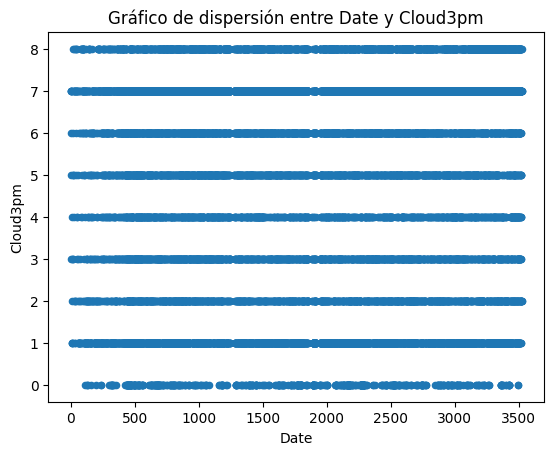

In [84]:
#graf_dispersion(df, df.columns[2], df.columns[2])
graf_dispersion(df_train, 'Date', 'Cloud3pm')

In [ ]:
#graf_dispersion(df[df['Location'] == 'Adelaide'],'Date','Cloud3pm')
df_train[df_train['Location'] == 'Adelaide']